# Generování syntetického EKG signálu pomocí diferenciálních rovnic

## Zadání

Tato seminární práce se zaměřuje na simulaci EKG signálů pomocí reakčně-difuzního modelu s prostorovou diskretizací [[1]](https://doi.org/10.1038/s41598-019-55448-5). Cílem práce bylo reprodukovat EKG signál odpovídající zdravému jedinci a signály odpovídající specifickým srdečním onemocněním. Následně byly vygenerované signály porovnány se skutečnými signály z databáze PhysioNet.

### Matematický model pro generování syntetického signálu
Zavedeme reakčně-difuzní model s prostorovou diskretizaci popsaný v článku. Diferenciální rovnice budou převedeny do výpočetního rámce pro simulaci EKG signálů.

\begin{array}{rcl}{\dot{x}}_{1} & = & {x}_{1}-{x}_{2}-C{x}_{1}{x}_{2}-{x}_{1}{{x}_{2}^{2}},\\ {\dot{x}}_{2} & = & H{x}_{1}-3{x}_{2}+C{x}_{1}{x}_{2}+{x}_{1}{{x}_{2}^{2}}+\beta ({x}_{4}-{x}_{2}),\\ {\dot{x}}_{3} & = & {x}_{3}-{x}_{4}-C{x}_{3}{x}_{4}-{x}_{3}{{x}_{4}^{2}},\\ {\dot{x}}_{4} & = & H{x}_{3}-3{x}_{4}+C{x}_{3}{x}_{4}+{x}_{3}{{x}_{4}^{2}}+2\beta ({x}_{2}-{x}_{4}),\\ ECG(t) & = & {\alpha }_{1}{x}_{1}+{\alpha }_{2}{x}_{2}+{\alpha }_{3}{x}_{3}+{\alpha }_{4}{x}_{4}\mathrm{}.\end{array}

### Autoři
- **František Čmuchař**
- **Petr Fridrich**
- **Milan Gittler**
- **David Holý**

## Implementace

### Knihovny

In [66]:
from functools import partial
from pathlib import Path

import numpy as np
import numpy.typing as npt
import optuna
from optuna.samplers import CmaEsSampler
from wfdb.io import Record, Annotation, rdrecord, rdann
from typing import Iterator
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Implementace Runge–Kutta & přidružených funkcí

In [10]:
# differential equations ov equation x1 - x4
def _dif_x13(x1_3, x2_4, C):
  return x1_3 - x2_4 - C*x1_3*x2_4 - x1_3*x2_4**2

def _dif_x2(x1, x2, x4, C, H, beta):
  return H*x1 - 3*x2 + C*x1*x2 + x1*x2**2 + beta*(x4 - x2)

def _dif_x4(x1, x2, x3, x4, C, H, beta):
  return H*x3 - 3*x4 + C*x3*x4 + x3*x4**2 + 2*beta*(x2 - x4)

def _runge_kutta_4(x, beta, H, C, step, gamma) :
    kx = np.zeros((4,4))

    # First iteration is a special case
    kx[0,0], kx[1,0] = _dif_x13(x[0], x[1], C), _dif_x2(x[0], x[1], x[3], C, H, beta)
    kx[2,0], kx[3,0] = _dif_x13(x[2], x[3], C), _dif_x4(x[0], x[1], x[2], x[3], C, H, beta)

    new_xs = [0] * 4
    for i in range(1, 4):
        factor = 0.5 if i < 3 else 1
        for j,_ in enumerate(new_xs):
          new_xs[j] = x[j] + factor * step * kx[j, i - 1]

        kx[0, i] = _dif_x13(new_xs[0], new_xs[1], C)
        kx[1, i] = _dif_x2(new_xs[0], new_xs[1], new_xs[3], C, H, beta)
        kx[2, i] = _dif_x13(new_xs[2], new_xs[3], C)
        kx[3, i] = _dif_x4(new_xs[0], new_xs[1], new_xs[2], new_xs[3], C, H, beta)

    # Final computation
    for i,_ in enumerate(new_xs):
      new_xs[i] = x[i] + step / 6 * (kx[i,0] + 2 * kx[i,1] + 2 * kx[i,2] + kx[i,3]) * gamma

    return new_xs

def generate_ecg(C: float, H: float, alpha: npt.NDArray, beta: float, HRbpm: int, time: float, step: float, startup_time: float = 0, gamma: float | None = None):
  time += startup_time
  X = np.zeros((4, int(time/step) + 1))
  X[2, 0] = 0.1

  if not gamma:
    gamma = 0.08804 * HRbpm - 0.06754

  for t in range(int(time/step)):
    new_xs = _runge_kutta_4(X[:,t], beta, H, C, step, gamma) 

    for i, xi in enumerate(new_xs):
      X[i, t+1] = xi

  ECG = alpha[0] * X[0,:] + alpha[1] * X[1, :] + alpha[2] * X[2, :] + alpha[3] * X[3, :]
  return ECG[int(startup_time / step) + 1:], X[int(startup_time/step) + 1 :]

### Generování zdravého EKG signálu

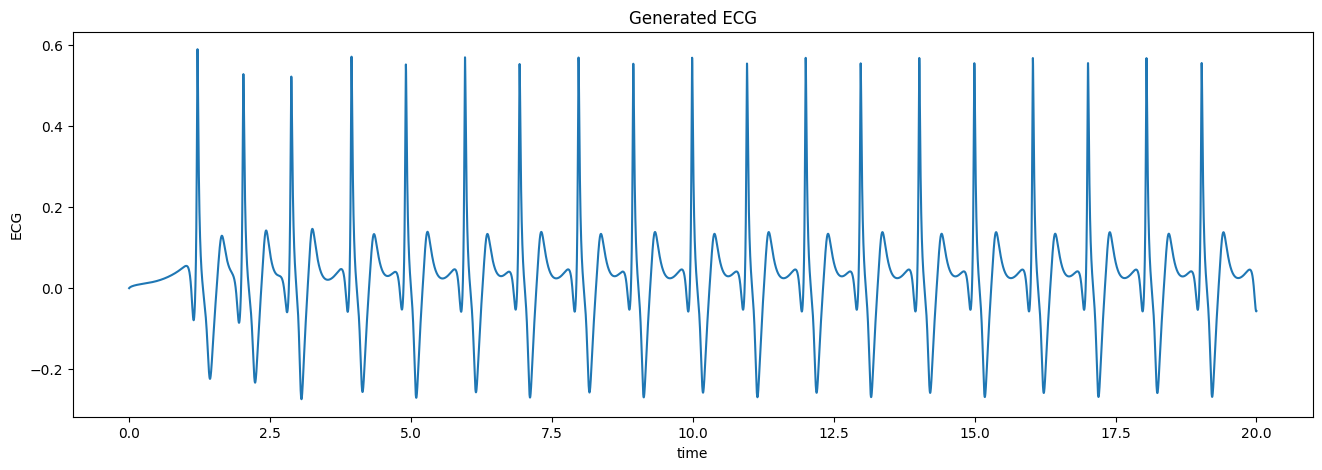

In [11]:
step = 0.0001
time = 20
HRbpm = 60
beta = 4.0
alpha = np.array([-0.024, 0.0216, -0.0012, 0.12])
H = 3.0
C = 1.35

ECG, X = generate_ecg(C=C, H=H, alpha=alpha, beta=beta, HRbpm=HRbpm, time=time, step=step)

time_axes = np.arange(0, time, step)
plt.figure(figsize=(16, 5))
plt.title("Generated ECG")
plt.xlabel("time")
plt.ylabel("ECG")
plt.plot(time_axes, ECG)
plt.show()

### Kontrola stability

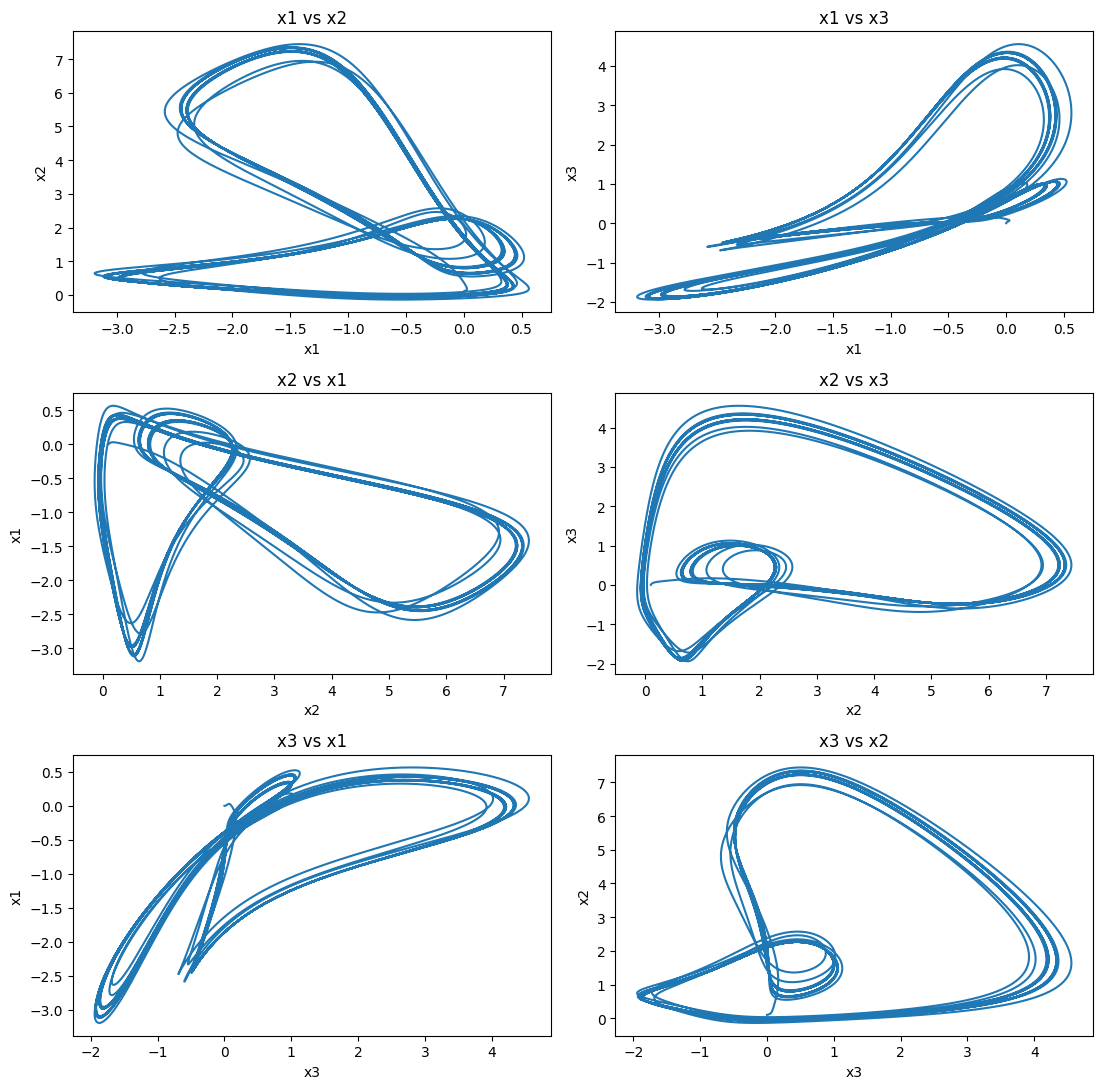

In [12]:
# Get the number of variables (vectors)
num_variables = X.shape[0]

# Calculate the number of rows and columns for subplots
num_rows = num_variables
num_cols = num_variables - 1  # Adjusting for the removed diagonal plots

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(11, 11))

# Loop through each combination of variables and create subplots
for i in range(num_rows):
    for j in range(num_cols):
        # Adjust the index to skip the diagonal plots
        index = j + 1 if j >= i else j

        # Plot the i-th and adjusted index-th vectors
        axes[i, j].plot(X[i, :], X[index, :])
        axes[i, j].set_xlabel(f'x{i + 1}')
        axes[i, j].set_ylabel(f'x{index + 1}')
        axes[i, j].set_title(f'x{i + 1} vs x{index + 1}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Generování EKG s onemocněním podle tabulky

<img src="img/Parameters.PNG">

#### Sinus Tachycardia

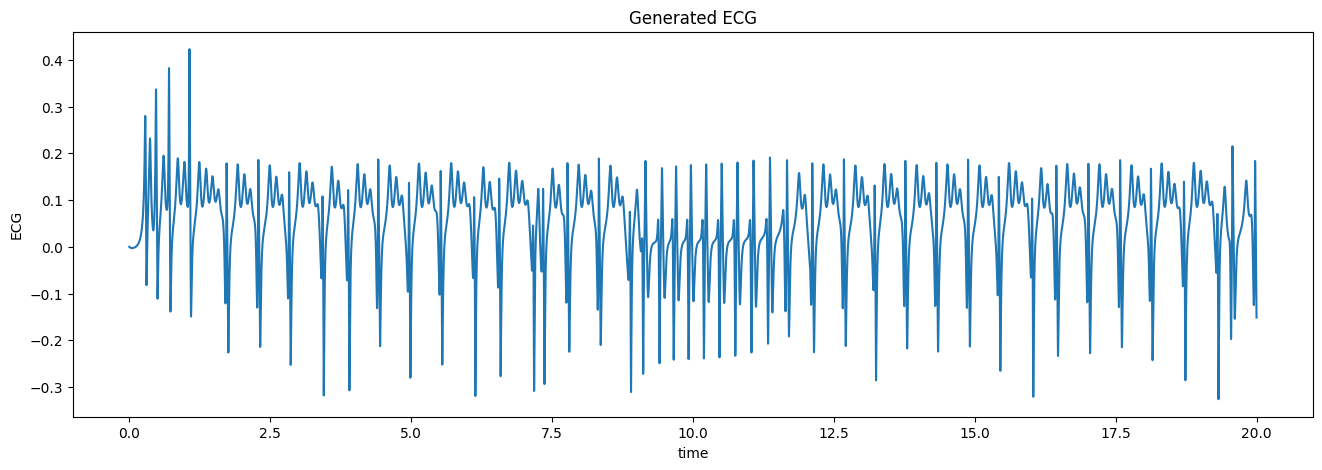

In [14]:
step = 0.00005
time = 20
HRbpm = 60
beta = 4.0
gamma = 21.0
alpha = np.array([0.0, -0.1, 0.0, 0.0])
H = 2.848
C = 1.35

ECG, X = generate_ecg(C=C, H=H, alpha=alpha, beta=beta, HRbpm=HRbpm, time=time, step=step, gamma=gamma)

time_axes = np.arange(0, time, step)
plt.figure(figsize=(16, 5))
plt.title("Generated ECG")
plt.xlabel("time")
plt.ylabel("ECG")
plt.plot(time_axes, ECG)
plt.show()

#### Atrial Flutter

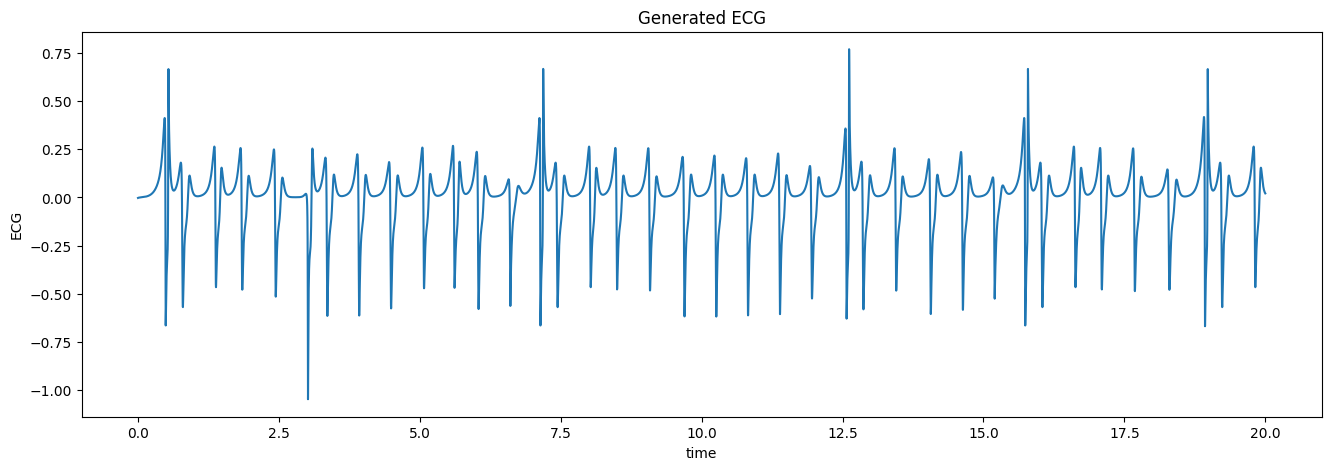

In [16]:
step = 0.00005
time = 20
HRbpm = 60
beta = 4.0
gamma = 13.0
alpha = np.array([-0.068, 0.028, -0.024, 0.12])
H = 1.52
C = 1.35

ECG, X = generate_ecg(C=C, H=H, alpha=alpha, beta=beta, HRbpm=HRbpm, time=time, step=step, gamma=gamma)

time_axes = np.arange(0, time, step)
plt.figure(figsize=(16, 5))
plt.title("Generated ECG")
plt.xlabel("time")
plt.ylabel("ECG")
plt.plot(time_axes, ECG)
plt.show()

#### Ventricular Tachycardia

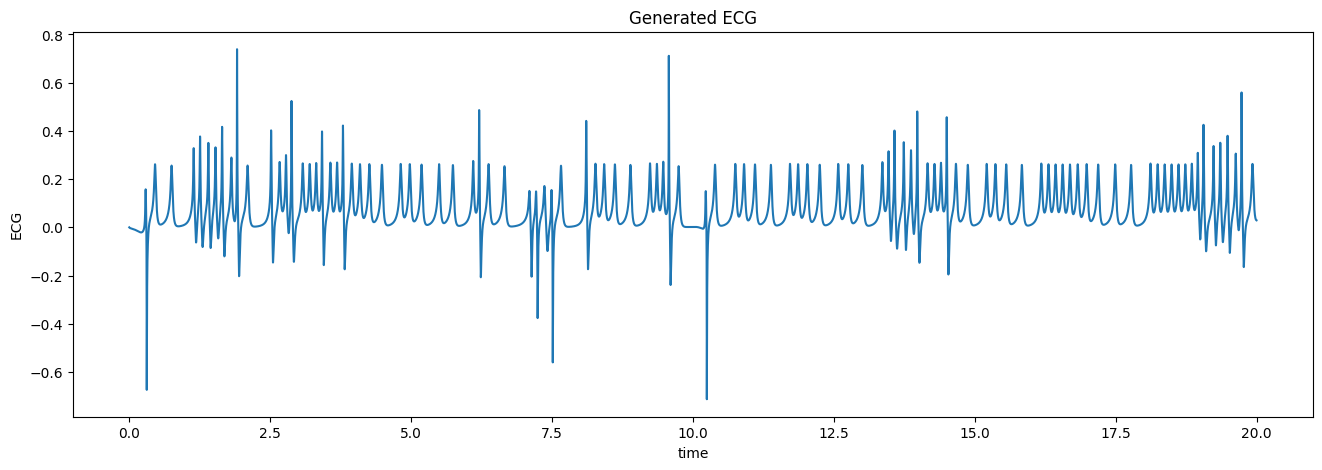

In [17]:
step = 0.00005
time = 20
HRbpm = 60
beta = 4.0
gamma = 21.0
alpha = np.array([0.0, 0.0, 0.0, -0.1])
H = 2.178
C = 1.35

ECG, X = generate_ecg(C=C, H=H, alpha=alpha, beta=beta, HRbpm=HRbpm, time=time, step=step, gamma=gamma)

time_axes = np.arange(0, time, step)
plt.figure(figsize=(16, 5))
plt.title("Generated ECG")
plt.xlabel("time")
plt.ylabel("ECG")
plt.plot(time_axes, ECG)
plt.show()

#### Ventricular Flutter

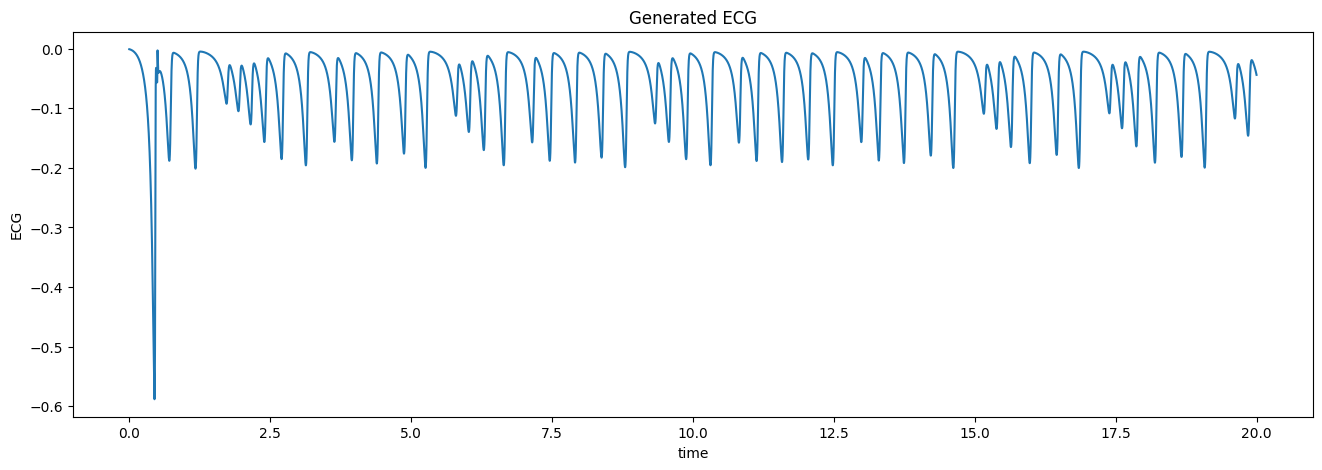

In [18]:
step = 0.00005
time = 20
HRbpm = 60
beta = 4.0
gamma = 13.0
alpha = np.array([0.1, -0.02, -0.01, 0.0])
H = 2.178
C = 1.35

ECG, X = generate_ecg(C=C, H=H, alpha=alpha, beta=beta, HRbpm=HRbpm, time=time, step=step, gamma=gamma)

time_axes = np.arange(0, time, step)
plt.figure(figsize=(16, 5))
plt.title("Generated ECG")
plt.xlabel("time")
plt.ylabel("ECG")
plt.plot(time_axes, ECG)
plt.show()

## Výsledky

Po aplikaci těchto parametrů jsme nenalezli očekávané výsledky. Z grafů je patrné, že zvěřejněné parametry pro generování ekg signálů onemocnění nedávájí shodné výsledky, které byly publikovány v článku. Z tohoto důvodu jsme se rozhodli neprovádět další analýzu, abychom zjistili, nakolik se generované signály nemocí liší od skutečných dat. Rozhodli jsme se tedy najít parametry svépomocí s využitím knihovny Optuna, na kterou se podíváme níže.

---
# Hledání optimálních parametrů pomocí Optuna

In [19]:
PARALLEL_JOBS = 8
BASE_SIGNAL_FOLDER = Path("data/signals/vybrane")

In [67]:
def calculate_hr(record: Record, ann:Annotation):
    return 60 /(len(record.p_signal)/record.fs) * len([i for i,x in enumerate(ann.symbol) if x =="N"]) # type: ignore

def read_signals(path: Path,sampfrom: int = 0, sampto:int | None = None) -> Iterator[tuple[Annotation, Record]]:
    for header in path.glob("*.hea"):
        ann = rdann(str(header.with_suffix("")), extension="i", return_label_elements=["symbol","label_store","description"])

        sig = rdrecord(header.with_suffix(""),sampfrom=sampfrom,sampto=sampto)
        yield ann, sig

## Funkce pro generování signálu

In [20]:
def generate_signal(study: optuna.study.Study, HRbpm: float):
    "generate signal for given optuna study parameters"

    step = 1/500
    time = 10
    # HRbpm = calculate_hr(record,ann)
    beta = 4
    alpha = np.array(
        [
            study.best_params["a1"],
            study.best_params["a2"],
            study.best_params["a3"],
            study.best_params["a4"],
        ])
    H = study.best_params["H"]
    C = 1.35

    return generate_ecg(
        H=H, C=C, alpha=alpha, beta=beta, HRbpm=HRbpm, time=time, step=step, startup_time=study.best_params["st"]
    )

## Loss funkce

#### Funkce max_min_peak_loss  
Tato loss funkce je navržena k porovnání dvou signálů: naměřeného signálu a vygenerovaného signálu. Má za úkol měřit rozdíl mezi maximálními a minimálními hodnotami vrcholů mezi skutečným a vygenerovaným signálem v definovaných oknech.
  
Funkce rozdělí každý signál na menší okna o velikosti window_len.
Pro každé okno vypočítá druhý rozdíl mezi maximálními a minimálními hodnotami skutečného a vygenerovaného signálu.
Tyto druhé rozdíly jsou shromážděny do samostatných seznamů pro maxima a minima.
Funkce poté vrátí součet maximálních hodnot z obou seznamů windows_max a windows_min.

Tato ztrátová funkce je užitečná v situacích, kde jsou vrcholy signálů (jak vysoké, tak nízké) klíčové, například při analýze EKG signálů. Zajišťuje, že vygenerovaný signál těsně odpovídá skutečnému signálu co nejvíce výškovými a nejnižšími body v každém okně.

In [21]:
def max_min_peak_loss(signal: npt.NDArray, generated_signal: npt.NDArray, window_len: int) -> float:
    windows_max = []
    windows_min = []
    splits = int(len(signal) / window_len)
    for signal_window, generated_signal_window in zip(np.split(signal,splits),np.split(generated_signal, splits)):
        windows_max.append(np.square(generated_signal_window.max() - signal_window.max()))
        windows_min.append(np.square(generated_signal_window.min() - signal_window.min()))
    return np.asarray(windows_max).max() + np.asarray(windows_min).max()

## Funkce pro minimalizaci

Následující metoda je navržena jako součást optimalizačního procesu pomocí Optuna. Tato funkce má za cíl najít nejlepší parametry pro generování EKG (elektrokardiogramových) signálů, které odpovídají reálným EKG signálům. Používá kombinaci vlastní ztrátové funkce (max_min_peak_loss) a Mean Squared Error (MSE) pro evaluaci.

Pro každý záznam EKG je spočítána srdeční frekvence (HRbpm).
Umělý EKG signál je generován s použitím těchto parametrů.
Prvních a posledních 500 vzorků vygenerovaného signálu je odebráno, kvůli neoznačení dat.

V kombinaci s max min peak loss funkcí se taktéž vypočítá Mean Squared Error (MSE) mezi vygenerovanými a skutečnými signály. Peak loss a MSE jsou sečteny, aby vytvořily kombinovanou ztrátovou hodnotu pro každý záznam. Tímto způsobem je zajištěno, že jsou v optimalizaci zohledňovány jak zarovnání vrcholů, tak celková podobnost vlnění.

Tím, že metoda vyhodnocuje různé sady parametrů a minimalizuje kombinovanou ztrátu, může Optuna identifikovat hodnoty parametrů, které nejlépe reprodukují charakteristiky reálných EKG signálů.

In [24]:
def objective(trial:optuna.Trial, records: Path):
    losses = []

    #define search space for parameters
    beta = 4
    startup_time = trial.suggest_float("st", 0, 1) #find the warmup time for the geenrated signal which will be cuted out
    alpha = np.asarray(
        [
            trial.suggest_float("a1", -0.2, 0.2),
            trial.suggest_float("a2", -0.2, 0.2),
            trial.suggest_float("a3", -0.2, 0.2),
            trial.suggest_float("a4", -0.2, 0.2),
        ]
    )
    mul = trial.suggest_float("mul", 1, 2) #multiplier for final multiplication. The generated signal need's to be multipied for more freedom for fi fitting. Without it the generated signal will stay rigid
    H = trial.suggest_float("H", 2, 4)
    C = 1.35
    time = 10
    step = 1/500

    for ann, record in read_signals(records):
        HRbpm = calculate_hr(record,ann) # calculate hr of the signal by given r peaks
        generated_ecg, x = generate_ecg(
            H=H, C=C, alpha=alpha, beta=beta, HRbpm=HRbpm, time=time, step=step, startup_time=startup_time
        ) #generate artificiall signal
        generated_ecg = generated_ecg[500:-500] # remove first and last half second, it is unnanotated
        generated_ecg *= mul

        #TODO: for siplicity just grab 1 lead
        signal = record.p_signal.T[1][500:-500] #type: ignore

        peak_loss = (
            max_min_peak_loss(signal, generated_ecg, 250) +
            max_min_peak_loss(signal, generated_ecg, 125)
        )/2
        losses.append(peak_loss + np.square(generated_ecg - signal).mean())
        return losses[0] # TODO: now just optimize for the first patient
    # return np.asarray(losses).mean()

## Simulování nemocí

In [76]:
def plot_record(record: Record, generated: npt.NDArray = None):
    if record is None:
        raise Exception("Need to have loaded signal in record")

    figure = make_subplots(rows=1, cols=1)

    # Plotting the specified signal from the record
    figure.add_trace(
        go.Scatter(
            y=record,
            x=list(range(record.shape[0])),
            showlegend=False, line={"color": "blue"}
        ),
        row=1, col=1
    )

    # Plotting the generated signal if provided
    if generated is not None:
        figure.add_trace(
            go.Scatter(
                y=generated,
                x=list(range(record.shape[0])),
                showlegend=False, line={"color": "red"}
            ),
            row=1, col=1
        )

    figure.update_layout(height=500, width=2000)
    return figure

### Sinus tachycardia

In [25]:
study_tachy = optuna.create_study(sampler=CmaEsSampler(restart_strategy="ipop")) # the cmaes sampler semm's to be best, can be replaced by other's
study_tachy.optimize(partial(objective, records = BASE_SIGNAL_FOLDER / "sinus_tachicardia"), 5000, n_jobs=PARALLEL_JOBS)

c:\Users\Cemonix\Desktop\VŠE\School\Sys\ecg_simulation\.venv\Lib\site-packages\optuna\samplers\_cmaes.py:288: ExperimentalWarning: `restart_strategy` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-01-24 15:49:36,998] A new study created in memory with name: no-name-0f3b4a13-29e9-4e7a-bf2d-c306d16728cb
[I 2024-01-24 15:49:37,194] Trial 0 finished with value: 3.0748273642757407 and parameters: {'st': 0.6390447418618826, 'a1': 0.15382602267948947, 'a2': 0.059756498433287064, 'a3': 0.08658210063244287, 'a4': -0.1088720380963836, 'mul': 1.566433677976009, 'H': 2.5136555167629675}. Best is trial 0 with value: 3.0748273642757407.
[I 2024-01-24 15:49:37,287] Trial 1 finished with value: 11.134848961357292 and parameters: {'st': 0.6597859272995568, 'a1': 0.07718050127629572, 'a2': 0.1321414447523469, 'a3': -0.09237792811137382, 'a4': 0.15615498238300163, 'mul': 1.6738357770208756, 'H': 2.074239820907952}. Best is trial 0 with value: 3.0748273

In [26]:
study_tachy.best_params

{'st': 0.7014467765889556,
 'a1': 0.054934319547751465,
 'a2': -0.11465937283192401,
 'a3': -0.018536116711236617,
 'a4': 0.013820491081593694,
 'mul': 1.8647381727305619,
 'H': 3.884048959577707}

In [77]:
anns = list(read_signals(BASE_SIGNAL_FOLDER / "sinus_tachicardia"))[0]
generated_ecg = generate_signal(study_tachy, calculate_hr(anns[1],anns[0]))[0]
final = generated_ecg * study_tachy.best_params["mul"]
plot_record(anns[1].p_signal[:, 1], final).show()

### Sinus bradicardia

In [28]:
study_bradi = optuna.create_study(sampler=CmaEsSampler(restart_strategy="ipop"))
study_bradi.optimize(partial(objective, records = BASE_SIGNAL_FOLDER / "sinus_bradicardia"), 5000, n_jobs=PARALLEL_JOBS)

c:\Users\Cemonix\Desktop\VŠE\School\Sys\ecg_simulation\.venv\Lib\site-packages\optuna\samplers\_cmaes.py:288: ExperimentalWarning:

`restart_strategy` option is an experimental feature. The interface can change in the future.

[I 2024-01-24 15:56:23,155] A new study created in memory with name: no-name-69e59c3a-9e7b-4896-89f3-294b6c0c399a
[I 2024-01-24 15:56:23,346] Trial 0 finished with value: 9.224756492329822 and parameters: {'st': 0.24827275505896396, 'a1': -0.10732907403456267, 'a2': -0.15125785008812948, 'a3': 0.17687616909828846, 'a4': -0.0841715746814487, 'mul': 1.4026475462429415, 'H': 2.246515248560627}. Best is trial 0 with value: 9.224756492329822.
[I 2024-01-24 15:56:23,417] Trial 2 finished with value: 3.269307425079393 and parameters: {'st': 0.6116743349063879, 'a1': 0.005891413674805918, 'a2': 0.11234175201272623, 'a3': 0.15185323069975748, 'a4': -0.16363857667535708, 'mul': 1.800275598377965, 'H': 3.106121281678676}. Best is trial 2 with value: 3.269307425079393.
[I 20

In [29]:
study_bradi.best_params

{'st': 0.29265532183290316,
 'a1': 0.027623620554373035,
 'a2': 0.09248937336350671,
 'a3': 0.09290877204968051,
 'a4': -0.06587063411459479,
 'mul': 1.645829202024427,
 'H': 3.8250744373910264}

In [78]:
anns = list(read_signals(BASE_SIGNAL_FOLDER / "sinus_bradicardia"))[0]
generated_ecg = generate_signal(study_bradi, calculate_hr(anns[1], anns[0]))[0]
final = generated_ecg * study_tachy.best_params["mul"]
plot_record(anns[1].p_signal[:, 1], final).show()

### Atrial flutter

In [31]:
study_arti = optuna.create_study(sampler=CmaEsSampler(restart_strategy="ipop"))
study_arti.optimize(partial(objective, records = BASE_SIGNAL_FOLDER / "atrial_flutter"), 5000, n_jobs=PARALLEL_JOBS)

c:\Users\Cemonix\Desktop\VŠE\School\Sys\ecg_simulation\.venv\Lib\site-packages\optuna\samplers\_cmaes.py:288: ExperimentalWarning:

`restart_strategy` option is an experimental feature. The interface can change in the future.

[I 2024-01-24 16:02:58,612] A new study created in memory with name: no-name-c8a1a3e9-aa7f-4e72-bb40-469f06f20338
[I 2024-01-24 16:02:58,788] Trial 1 finished with value: 17.116866354108957 and parameters: {'st': 0.03693968218638288, 'a1': -0.06205959687744339, 'a2': 0.10968495165447761, 'a3': -0.028807002541643645, 'a4': 0.18667836177814967, 'mul': 1.687548183583114, 'H': 2.9789042472898917}. Best is trial 1 with value: 17.116866354108957.
[I 2024-01-24 16:02:58,790] Trial 0 finished with value: 3.259625421733809 and parameters: {'st': 0.16213903747433134, 'a1': -0.1783672960847126, 'a2': 0.1552727905947483, 'a3': -0.09166385004667355, 'a4': 0.12936757834728813, 'mul': 1.5554431797906827, 'H': 3.619342315951279}. Best is trial 0 with value: 3.259625421733809.
[I

In [32]:
study_arti.best_params

{'st': 0.801926575761805,
 'a1': -0.06782395880176259,
 'a2': 0.019193802358333956,
 'a3': -0.031448519793476876,
 'a4': -0.03506005038058066,
 'mul': 1.6615923867078317,
 'H': 3.1753290709072184}

In [79]:
anns = list(read_signals(BASE_SIGNAL_FOLDER / "atrial_flutter"))[0]
generated_ecg = generate_signal(study_arti, calculate_hr(anns[1], anns[0]))[0]
final = generated_ecg * study_tachy.best_params["mul"]
plot_record(anns[1].p_signal[:, 1], final).show()

## Závěr

Během naší práce jsme se primárně soustředili na implementaci Runge-Kuttovy metody a vytváření realistického EKG signálu, což jsme úspěšně provedli, jak lze vidět v sekci *Generování zdravého EKG signálu*.

## Zdroje

+ https://www.nature.com/articles/s41598-019-55448-5
+ https://en.wikipedia.org/wiki/CMA-ES
+ https://optuna.org